## Settings

In [1]:
img_folder = "img"
filename = img_folder + "/{}.jpg"
data_num = 500

## Constants

In [2]:
w = 100
h = 28
align = 11
top_align = 2
down_align = 5

count = 6
span = (w - align * 2) // count
threshold = 115
num_classes = 10

## Load Base64 Text to Images

In [3]:
import os
import json
import base64

In [4]:
def Base64toFile(b64: str, filename: str):
    with open(filename, 'wb') as f:
        f.write(base64.b64decode(b64))

In [5]:
if not os.path.exists(img_folder):
    os.mkdir(img_folder)

with open('data.json') as r:
    data = json.load(r)

    _i = 0
    for d in data['data']:
        Base64toFile(d, filename.format(_i))
        _i = _i + 1

## Image Test

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(28, 100, 3)


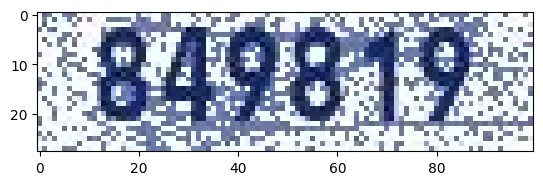

In [7]:
I = cv2.cvtColor(cv2.imread(filename.format(100)), cv2.COLOR_BGR2RGB).astype(np.uint8)
print(I.shape)
plt.imshow(I)
plt.show()

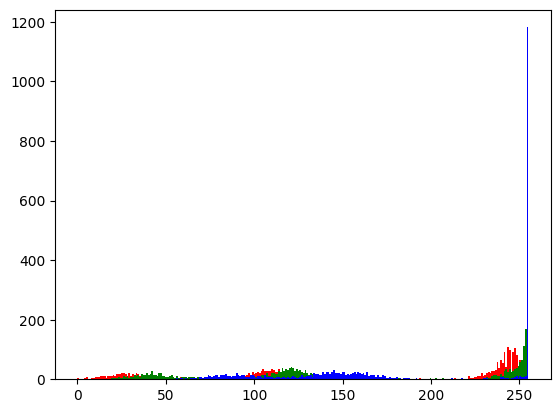

In [8]:
plt.hist(I[:, :, 0].flatten(), 256, (0, 255), color='red') # R
plt.hist(I[:, :, 1].flatten(), 256, (0, 255), color='green') # G
plt.hist(I[:, :, 2].flatten(), 256, (0, 255), color='blue') # B
plt.show()

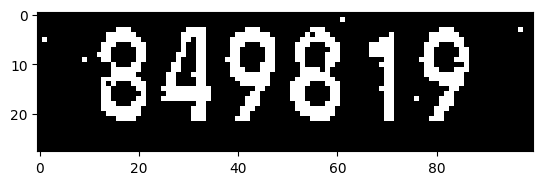

In [9]:
plt.imshow(I[:, :, 2] < 115, cmap = 'gray')
plt.show()

(21, 78)


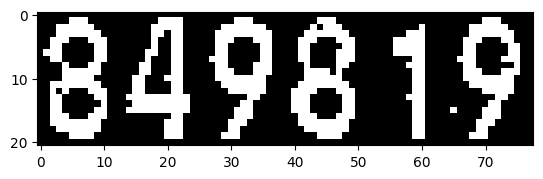

In [10]:
SI = I[top_align:h-down_align, align:w-align, 2] < threshold
print(SI.shape)
plt.imshow(SI, cmap='gray')
plt.show()

(6, 21, 13)


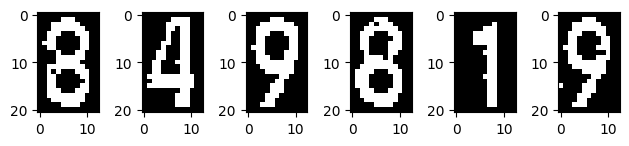

In [11]:
SNs = np.zeros((count, h - top_align - down_align, span), SI.dtype)
print(SNs.shape)
fig, ax = plt.subplots(1, count)
for i in range(count):
    SNs[i] = SI[:, i*span : (i + 1)*span]
    ax[i].imshow(SNs[i], cmap='gray')

plt.tight_layout()
plt.show()

# Images Processing

## Crop and Filiter Images

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def crop(_matrix: np.ndarray, _range: np.ndarray): # _range : (n, 2), uint
    result = _matrix.copy()
    for i in range(len(_range)):
        result = result.take(range(_range[i, 0], _range[i, 1]), i)
    return result

In [14]:
def getTrainingImages(code_img: np.ndarray) -> np.ndarray:
    I = crop(code_img.copy().take(2, 2) < threshold, np.array([[top_align, h - down_align], [align, w - align]]))

    SNs = np.zeros((count, h - top_align - down_align, span), I.dtype)
    for i in range(count):
        SNs[i] = I.take(range(i*span, (i+1)*span), 1)

    return SNs

## Classify Images Data

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from IPython.display import clear_output

In [16]:
def load_data(filename: str):
    try:
        with open(filename, 'r') as r:
            data = json.load(r)
        
        return int(data['start']), np.array(data['x'], dtype=np.uint8), np.array(data['y'], dtype=np.uint8)
    except:
        return int(0), np.zeros((data_num * count, h - top_align - down_align, span), dtype=np.uint8), np.zeros((data_num * count), dtype=np.uint8)

In [17]:
def save_data(filename: str, start: int, x: np.ndarray, y: np.ndarray):
    with open(filename, 'w') as w:
        json.dump({'start': start, 'x': x.tolist(), 'y': y.tolist()}, w)

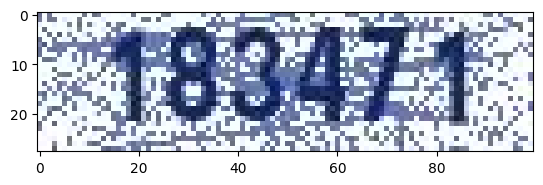

In [18]:
start, x_train, y_train = load_data('train_set.json')

step = 10
for n in range(start, start + step if start + step < data_num else data_num):
    I = cv2.cvtColor(cv2.imread(filename.format(n)), cv2.COLOR_BGR2RGB).astype(np.uint8)
    plt.imshow(I)
    plt.show()

    y_train[n*count : (n+1)*count] = [int(s) for s in input(filename.format(n))]
    x_train[n*count : (n+1)*count] = getTrainingImages(I)

    start = n + 1
    clear_output(True)

save_data('train_set.json', start, x_train, y_train)

# Method 1: Use AI Learning

In [19]:
from keras import layers, models

## Create Model

In [20]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(h - top_align - down_align, span, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='sigmoid'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 5, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 3, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 1, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 3, 1, 64)          0         
                                                                 
 flatten (Flatten)           (None, 192)               0

## Train Model

In [21]:
history = model.fit(x_train[:start], y_train[:start], epochs = 5, batch_size = 10, validation_split = 0.2)
model.save_weights('ilearning_tf2_mlp.h5', save_format='h5')

Epoch 1/5


32/32 [==============================] - 1s 7ms/step - loss: 2.3803 - accuracy: 0.1219 - val_loss: 1.9952 - val_accuracy: 0.2750
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 1.9105 - accuracy: 0.3125 - val_loss: 1.3014 - val_accuracy: 0.8625
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 1.0258 - accuracy: 0.7563 - val_loss: 0.5325 - val_accuracy: 1.0000
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.4660 - accuracy: 0.9375 - val_loss: 0.2137 - val_accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2906 - accuracy: 0.9750 - val_loss: 0.1020 - val_accuracy: 1.0000


## Predict

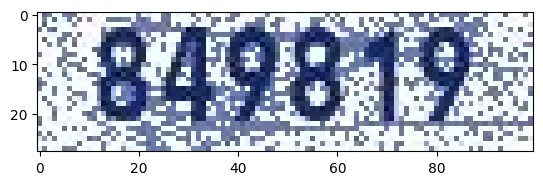

1/1 [==============================] - 0s 77ms/step


array([8, 4, 9, 8, 1, 9], dtype=int64)

In [22]:
model.load_weights('ilearning_tf2_mlp.h5')

I = cv2.cvtColor(cv2.imread(filename.format(100)), cv2.COLOR_BGR2RGB).astype(np.uint8)
plt.imshow(I)
plt.show()

np.argmax(model.predict(getTrainingImages(I)), axis = 1)

# Method 2: Use Traditional Prediction

## Create Standard Images of Numbers

In [23]:
code_1 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

code_2 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

code_3 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

code_4 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0], 
         [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

code_5 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

code_6 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

code_7 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

code_8 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

code_9 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], 
         [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], 
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

code_numbers = [code_1, code_2, code_3, code_4, code_5, code_6, code_7, code_8, code_9]

## Predict

In [24]:
def predict(obj: np.ndarray, standard_sets: np.ndarray):
    return np.argmin([np.array(np.abs(obj - i)).sum() for i in standard_sets])

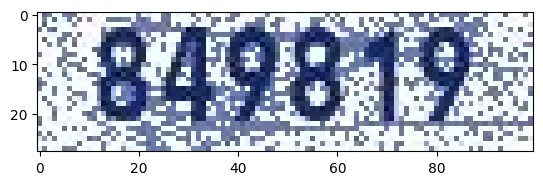

[8, 4, 9, 8, 1, 9]


In [25]:
I = cv2.cvtColor(cv2.imread(filename.format(100)), cv2.COLOR_BGR2RGB).astype(np.uint8)
plt.imshow(I)
plt.show()
print([predict(i, np.array(code_numbers)) + 1 for i in getTrainingImages(I)])